# 

# TODO
- reinstall transformers with pytorch-nightly so that can use `mps` device

# Few to No Labels
Concepts Covered:
* Multi-label classification
* Baseline: Naive Bayes cast as a one-vs-rest problem (using `scikit-multilearn`)
* zero-shot classfication: recasting problem as a text entailment problem. 
    * top k vs threshold approach
* Text data augmentation (`nlpaug` library) 
* Using embeddings as a lookup table (FAISS)
    * how many neighbors? what threshold?
* Fine-Tuning a Vanilla Transformer
* Domain Adaptation: Fine-Tuning language model on unlabeled data before training model on labeled data.


**Original Application**: Github issue tagging  
**Potential Application at Nike**: NEoD conversation tagging

## Dataset Preparation


In [2]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from skmultilearn.model_selection import iterative_stratification
import torch
import transformers as tfm

import fewlabels as fl
from fewlabels.preproc import Batch

%load_ext autoreload
%autoreload 2

DATASET_URL = "https://git.io/nlp-with-transformers"

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_issues = pd.read_json(DATASET_URL, lines=True)

print(f"Dataframe shape: {df_issues.shape}")

# only keep label name (drop id, nodes, ...)
df_issues["labels"] = df_issues.labels.apply(lambda l: [n['name'] for n in l])

# keep main labels and map to simpler lower case labels
LABEL_MAP = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(labels: list[str]) -> list[str]:
    return [LABEL_MAP[label] for label in labels if label in LABEL_MAP]

df_issues["labels"] = df_issues.labels.apply(filter_labels)
all_labels = list(LABEL_MAP.values())

# adding a flag to know whether issue has at least one labeled or not
df_issues["labeled"] = df_issues.labels.apply(len) > 0


# drop duplicates
df_issues["text"] = df_issues.title + "\n\n" + df_issues.body
previous_length = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")

print(f"duplicates dropped: {previous_length - len(df_issues)}")

Dataframe shape: (9930, 26)
duplicates dropped: 187


/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


## Exploratory Data Analysis

In [4]:
# how many issues are labeled/unlabeled?
print(df_issues.labeled
    .map({True: "labeled", False: "unlabeled"})
    .value_counts()
    .to_string()
)

unlabeled    9303
labeled       440


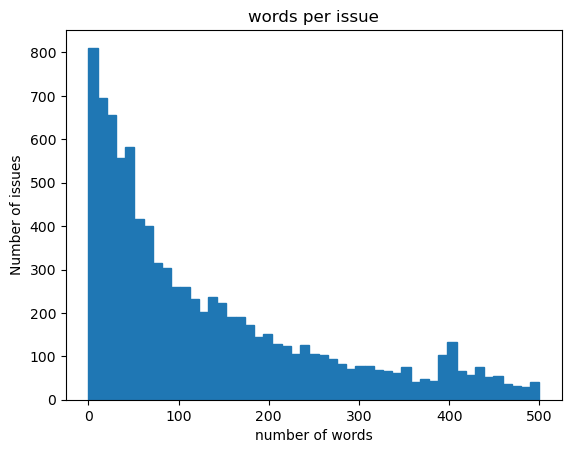

In [5]:
# word counts distribution per issue
(
    df_issues["text"].str.split()
    .apply(len)
    .hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0")
)
plt.title("words per issue")
plt.xlabel("number of words")
plt.ylabel("Number of issues")
plt.show()


### Labels distribution
Across labeled issues

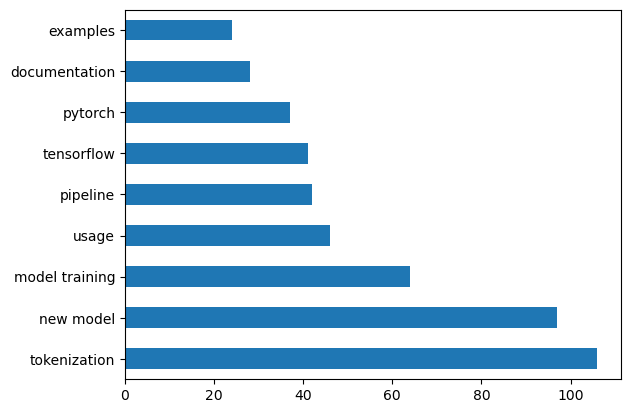

In [6]:

flattened_labels = df_issues.query("labeled == True").labels.sum()

_ = pd.Series(flattened_labels).value_counts().plot.barh()


# Creating a Training Set

In [7]:
# fit a label binarizer on data
mlb = sklearn.preprocessing.MultiLabelBinarizer()

mlb.fit([all_labels])
print(mlb.transform([["tokenization", "pytorch"], ["tensorflow"]]))


[[0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0]]


In [8]:

def balanced_split(df: pd.DataFrame, test_size: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    """allows to create stratified data splits for multilabel datasets."""
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_stratification.iterative_train_test_split(idx, labels, test_size=test_size)

    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df_issues[["text", "labels", "labeled"]].reset_index(drop=True).copy()

df_unsup = df_clean.loc[~df_clean.labeled, ["text","labels"]]
df_sup = df_clean.loc[df_clean.labeled, ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [9]:
ds = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": datasets.Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": datasets.Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": datasets.Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### Creating Training Slices
Goal: test how efficient different strategies are depending on number of labeled samples

In [10]:
# refactored
slice_sizes = [2**x for x in range(3,8)]
train_slices = fl.preproc.create_dataset_slices(ds["train"], slice_sizes, mlb=mlb, seed=0)

print(f"target split size: {slice_sizes}")
print(f"actual split size: {[len(s) for s in train_slices]}")

target split size: [8, 16, 32, 64, 128, 223]
actual split size: [10, 19, 36, 68, 134, 223]


In [11]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

100%|██████████| 10/10 [00:00<00:00, 507.82ba/s]


## Create Evaluator
The `SlicedTrainingEvaluator` fits a pipeline on training slices of various sizes and computes the f1-score (micro / macro) on the test set.

In [12]:
evaluator = fl.eval.SlicedTrainingEvaluator(ds=ds, train_slices=train_slices, mlb=mlb)

In [13]:
import pickle

with open("../data/outputs/f1_score_records.pkl", 'rb') as f:
    evaluator.f1_scores = pickle.load(f)

# Naive Bayes Baseline

In [65]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

strategy = "Naive Bayes"

pipe = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("clf", BinaryRelevance(classifier=MultinomialNB()))
    ])

evaluator.evaluate_pipe_on_slices(pipe, strategy=strategy)



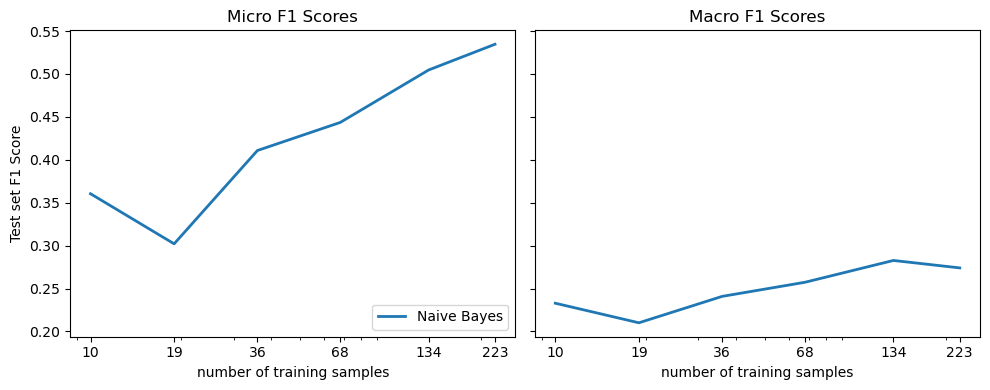

In [66]:
fl.plot.plot_metrics(evaluator, "Naive Bayes")

# Working with No Labeled Data: Zero-Shot Classification
* turn task into an entailment task to figure out whether topics are related by comparing text to a sentence of the form: `"this section was about the topic [MASK]"`
### Fill-Mask Models

In [67]:
FILL_MASK_CKPT = "bert-base-uncased"
pipe = tfm.pipeline("fill-mask", model=FILL_MASK_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
# demo
movie_desc = """Bi Gan follows up his knockout debut, Kaili Blues, 
with this noir-tinged stunner about a lost soul (Jue Huang) on a quest 
to find a missing woman from his past (Wei Tang). Following leads across Guizhou province, 
he crosses paths with a series of colorful characters, among them a prickly hairdresser 
played by Taiwanese superstar Sylvia Chang."""

prompt = "The movie takes place in [MASK]."


def print_zero_shot_output(context: str, prompt: str, targets: list[str] = None):
    output = pipe(movie_desc + prompt, targets=targets)
    for element in output:
        print(f"Token {element['token_str']}:\t{element['score']:.1%}")

print_zero_shot_output(movie_desc, prompt)

Token china:	57.7%
Token beijing:	8.4%
Token shanghai:	6.5%
Token taiwan:	4.5%
Token yunnan:	3.1%


In [84]:
# adding candidate tokens
print_zero_shot_output(movie_desc, prompt, targets=["china", "taiwan", "korea", "japan"])


Token china:	57.7%
Token taiwan:	4.5%
Token japan:	0.3%
Token korea:	0.1%


In [85]:
desc = """DOUBLE THE AF1. DOUBLE THE FUN.
The Nike Air Force 1 Shadow puts a playful twist on a classic b-ball design. Using a layered approach, doubling the branding and exaggerating the midsole, it highlights AF-1 DNA with a bold, new look.
Layered Look
With 2 eyestays, 2 mudguards, 2 back tabs and 2 Swoosh designs, you get a layered look with double the branding.
Lightweight Comfort
A foam midsole and a grooved outsole ensure that the shoe is lightweight, flexible and comfortable.
Iconic Shape
Featuring the same iconic shape as the original Air Force 1, a slightly exaggerated midsole makes the shoe instantly recognizable while also playing with proportions."""
prompt = "this shoe feels [MASK]."

print_zero_shot_output(desc, prompt, targets=["comfortable", "responsive", "springy"])

The specified target token `springy` does not exist in the model vocabulary. Replacing with `spring`.


Token comfortable:	0.7%
Token spring:	0.0%
Token responsive:	0.0%


## Zero-Shot Classification Pipelines
* improving on the fill mask model by allowing for multi-token labels and using a model trained on Natural Language Inference tasks.

In [92]:
pipe = tfm.pipeline("zero-shot-classification")

# test on a sample
sample = ds["train"][0]
output = pipe(sample["text"], all_labels, multi_label=True)
print(f"Labels: {sample['labels']}")
print(f"Text: {output['sequence'][:300]}")
for label, score in zip(output["labels"], output["scores"]):
    print(f"{label:<20}{score:.3f}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Labels: ['new model']
Text: Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded
new model           0.984
examples            0.336
tensorflow          0.307
usage               0.297
pytorch             0.248
documentation       0.245
model training      0.235
tokenization        0.174
pipeline            0.160


In [97]:
# apply pipeline to validation set
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)
    

100%|██████████| 106/106 [11:46<00:00,  6.66s/ex]


## Evaluating best strategy to go from confidence scores to selected labels
Two options to define which labels should be selected:
* define a minimum threshold
* select top k labels with highest scores

In [115]:
# explore the threshold approach
# refactored
from typing import Any

Example = dict[str, list[Any]]


def get_preds_threshold(example: Example, threshold: float):
    return [
        label 
        for label, score in zip(example["predicted_labels"], example["scores"])
        if score >= threshold
        ]


def get_preds_topk(example: Example, topk: int) -> list[str]:
    return [
        example["predicted_labels"][i] for i in range(topk)
    ]

def convert_predictions_to_binary_list(preds: list[str]) -> list[int]:
    return list(np.squeeze(mlb.transform([preds])))

def get_all_preds(example: Example, threshold: float = None, topk: int = None) -> list[int]:
    if threshold:
        preds = get_preds_threshold(example, threshold)
    elif topk: 
        preds = get_preds_topk(example, topk)
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": convert_predictions_to_binary_list(preds)}


from sklearn.metrics import classification_report

def get_clf_report(ds: datasets.Dataset):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])

    return classification_report(y_true, y_pred,
        target_names=mlb.classes_,
        zero_division=0,
        output_dict=True)

# print topk and threshold perf

# refactored
def plot_zero_shot_perf_vs_kwarg(**kwargs: dict[str, list]) -> tuple[list[float]]:
    datasets.disable_progress_bar()
    micros, macros = [], []
    key, values = kwargs.popitem()
    assert key in ("topk", "threshold"), "accepts single argument which should take value `topk` or `threshold`"
    for value in values:
        ds_zero = ds_zero_shot.map(get_all_preds, batched=False, fn_kwargs={key: value})
        clf_report = get_clf_report(ds_zero)
        micros.append(clf_report['micro avg']['f1-score'])
        macros.append(clf_report['macro avg']['f1-score'])

    plt.plot(values, micros, label='Micro F1')
    plt.plot(values, macros, label="Macro F1")
    plt.xlabel(key.capitalize())
    plt.ylabel("F1-score")
    plt.legend(loc='best')
    plt.show()

    return micros, macros

assert sum(get_all_preds(ds_zero_shot[0], topk=3)["pred_label_ids"]) == 3


100%|██████████| 106/106 [00:00<00:00, 16024.37ex/s]


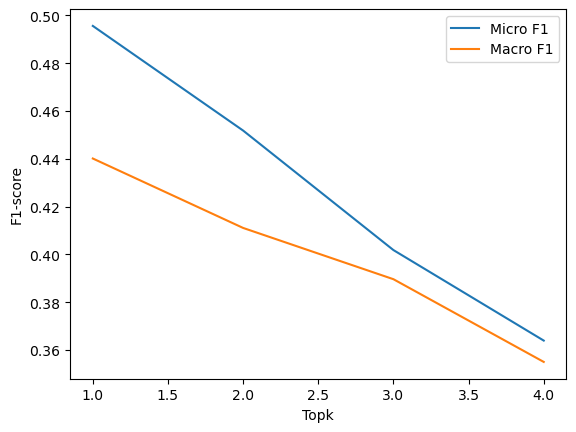

100%|██████████| 106/106 [00:00<00:00, 14372.88ex/s]


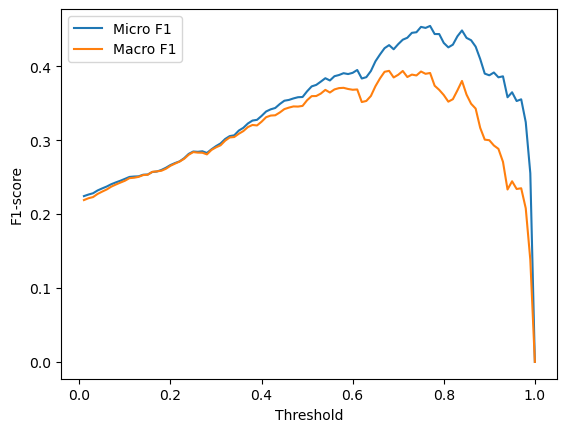

In [132]:
_ = plot_zero_shot_perf_vs_kwarg(topk=[1,2,3,4])

thresholds = np.linspace(0.01,1,100)
micros, macros = plot_zero_shot_perf_vs_kwarg(threshold=thresholds)

In [138]:
# refactored
def get_optimal_threshold(metric: list[float], metric_type: str) -> None:
    best_t, best_metric = thresholds[np.argmax(metric)], np.max(metric)
    print(f"best threshold ({metric_type}): {best_t} with F1-score {best_metric:.2f}")

get_optimal_threshold(micros, "micro")
get_optimal_threshold(macros, "macro")

best threshold (micro): 0.77 with F1-score 0.45
best threshold (macro): 0.68 with F1-score 0.39


Best performing method seems to be **top-1**

### Final Evaluation on test set

In [139]:
ds_zero_shot = ds["test"].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_all_preds, fn_kwargs={"topk": 1})
clf_report = get_clf_report(ds_zero_shot)


100%|██████████| 111/111 [00:00<00:00, 14020.59ex/s]


In [146]:
# record scores across train slices (zero shot == independent of train slices)
y_true = np.array(ds_zero_shot["label_ids"])
y_pred = np.array(ds_zero_shot["pred_label_ids"])

for slice in train_slices:
    evaluator.add_f1_scores(y_true, y_pred, "Zero Shot")

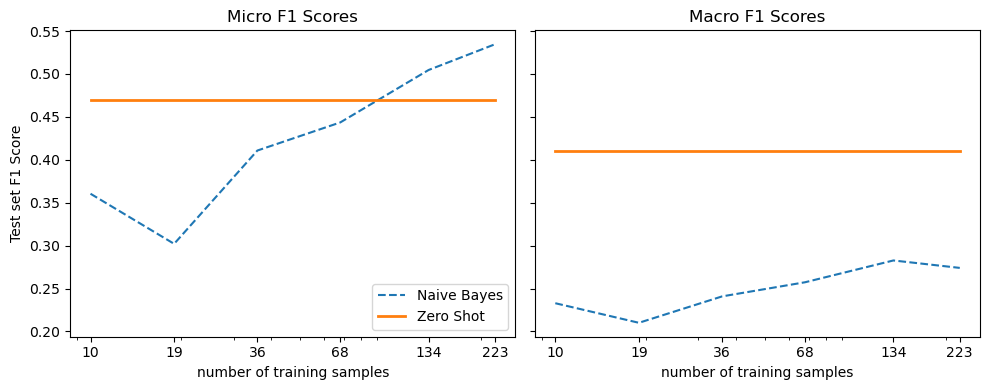

In [147]:
fl.plot.plot_metrics(evaluator, "Zero Shot")

# Working with Few Labels
## Data Augmentation

In [150]:
import nlpaug.augmenter.word as naw

AUGMENTER_CKPT = "distilbert-base-uncased"

aug = naw.ContextualWordEmbsAug(model_path=AUGMENTER_CKPT, 
    device="cpu", 
    action="substitute")

text = "I wonder how well this thing works."
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")


Original text: I wonder how well this thing works.
Augmented text: i question how exactly this thing works.


In [163]:
# refactored
from functools import partial

strategy = "Naive Bayes + Aug"

pipe = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("clf", BinaryRelevance(classifier=MultinomialNB()))
    ])


augment_fcn = partial(
    fl.augment.augment_batch,
    n_transformations=1, # number of augmentations per training example
    augment_fcn=aug.augment, # function to apply to create an augmented example given a single input text.
    )

evaluator.evaluate_pipe_on_slices(pipe, 
    strategy=strategy, 
    augment_fcn=augment_fcn)


100%|██████████| 1/1 [03:38<00:00, 218.18s/ba]


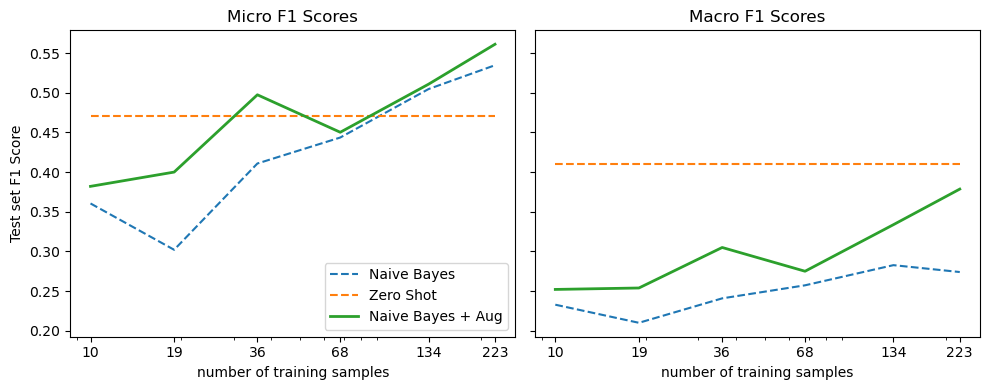

In [14]:
strategy = "Naive Bayes + Aug"
fl.plot.plot_metrics(evaluator, strategy)

## Embeddings as lookup tables
Approach: 
* turn all texts into embeddings
* find nearest `n_neighbors` to the query that are labeled.
* select a label if at least `threshold` neighbors are tagged with that same label.

In [15]:
MODEL_CKPT = "miguelvictor/python-gpt2-large"
tokenizer = tfm.AutoTokenizer.from_pretrained(MODEL_CKPT)
model = tfm.AutoModel.from_pretrained(MODEL_CKPT)

# adding pad token
tokenizer.add_special_tokens({'pad_token': '|pad|'})
model.resize_token_embeddings(len(tokenizer))

# other option: recycle existing special token tokenizer.pad_token = tokenizer.eos_token

text_embedder = fl.text_embeddings.TransformerWithMeanPooling(model)

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def get_text_embeddings(batch: Batch) -> Batch:
    inputs = tokenizer(
        batch["text"], 
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128)
    
    with torch.no_grad():
        pooled_embeddings = text_embedder(**inputs)

    return {
        "embeddings": pooled_embeddings.cpu().numpy()}

# verifying that text_embedder works as expected and returns one embedding per input text:
n = 5
assert get_text_embeddings(ds["train"][:n])["embeddings"].shape == (n, model.embed_dim)

### mapping dataset to get embeddings

In [17]:
def add_embeddings_to_dataset(ds: datasets.Dataset) -> datasets.Dataset:
    return ds.map(get_text_embeddings, batched=True, batch_size=16)

embs_train = add_embeddings_to_dataset(ds["train"])
embs_valid = add_embeddings_to_dataset(ds["valid"])
embs_test = add_embeddings_to_dataset(ds["test"])

100%|██████████| 7/7 [00:26<00:00,  3.76s/ba]


### Hyperparameter Search
Hyperparameters to optimize on valid dataset:
* `n_neighbors`: number of nearest neighbors to retrieve labels from
* `threshold`: minimum number of neighbors having a given label to select it for prediction

Bonus: 
* `MODEL_CKPT`: you can easily setup the evaluation pipeline to compare performance with various sentence encoders.

#### First pass: sweep other n_neighbors / threshold pairs and fine best parameters for f1-micro
* 

In [29]:
embs_train.add_faiss_index(column="embeddings")

100%|██████████| 1/1 [00:00<00:00, 173.94it/s]


Dataset({
    features: ['text', 'labels', 'label_ids', 'embeddings'],
    num_rows: 223
})

In [71]:
# test a single tagging strategy
tagger = fl.text_embeddings.KNNTagger(embs_train)

tagger.score(
    valid_ds=embs_valid, 
    k=10, 
    threshold=3)    

100%|██████████| 106/106 [00:00<00:00, 372.06ex/s]


{'micro': 0.5686274509803921, 'macro': 0.43816822326414845}

In [90]:
tagger.score(embs_valid, k=5, threshold=5)

100%|██████████| 106/106 [00:00<00:00, 665.66ex/s]


{'micro': 0.0, 'macro': 0.0}

In [107]:
# refactored
def gridsearch_on_f1_scores(
    tagger: fl.text_embeddings.KNNTagger, 
    valid_ds: datasets.Dataset,
    topk: int) -> tuple[np.ndarray, np.ndarray]:
    """returns two arrays: f1-micro and f1-macro scores for 
    all combinations of KNNTagger performance with:
    - k < topk and 
    - threshold < k"""
    topk = min(topk, len(tagger.train_ds))

    micro_scores = np.zeros((topk + 1, topk + 1))
    macro_scores = np.zeros((topk + 1, topk + 1))

    datasets.disable_progress_bar()

    for k in range(1, topk + 1):
        for threshold in range(1, k + 1):
            scores = tagger.score(
                valid_ds=embs_valid, 
                k=k, 
                threshold=threshold,
            )
            micro_scores[k, threshold] = scores["micro"]
            macro_scores[k, threshold] = scores["macro"]

    return micro_scores, macro_scores

micro_scores, macro_scores = gridsearch_on_f1_scores(tagger, embs_valid, topk=17)


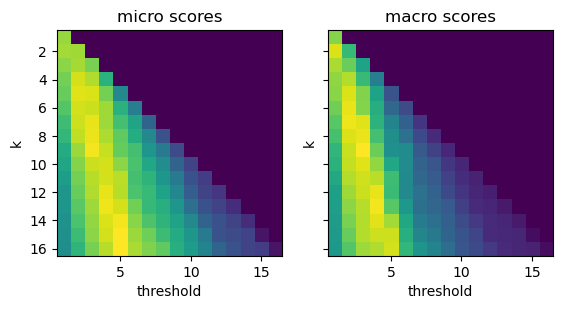

In [108]:
# refactored
fig = fl.plot.plot_gridsearch(micro_scores, macro_scores)

fig.savefig("../images/gridsearch.png")

In [109]:
def get_best_parameters(scores: np.ndarray) -> tuple[int, int]:
    return np.unravel_index(scores.argmax(), scores.shape)

best_k, best_threshold = get_best_parameters(micro_scores)
print(f"Best k: {best_k}, best threshold: {best_threshold}")

Best k: 15, best threshold: 5
